In [140]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [141]:
X_train = pd.read_csv("../datasets/songs-prediction-2025/train_x.csv", index_col=0)
y_train = pd.read_csv("../datasets/songs-prediction-2025/train_y.csv", index_col=0)

# EDA

In [142]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
count,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,...,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000
mean,43.394558,1.540279,8.378243,1.315349,-6.476035,-9.503415,-2.243164,-1.660698,3.543946,1.892996,...,15.657046,-72.008182,41.154440,37.892338,0.145765,17.576243,-28.502296,4.474666,17.717701,1.227647
std,6.074562,51.578894,35.742553,16.622971,22.823521,12.926176,14.700348,8.035388,10.629817,6.602191,...,32.539451,171.932584,120.075095,96.748418,16.162963,115.706029,180.463987,13.592096,185.335542,22.018997
min,7.199890,-302.031900,-257.525600,-120.723150,-142.160680,-60.198620,-100.602550,-51.443820,-75.539550,-31.344160,...,-224.101380,-1976.846950,-791.832320,-1237.931680,-227.608010,-2678.193680,-3059.906060,-100.618700,-5000.654060,-286.031200
25%,39.970260,-25.603507,-11.773080,-8.490435,-20.716735,-18.524397,-10.651808,-6.402985,-2.573275,-2.446435,...,-1.821028,-138.560657,-21.424297,-4.443660,-7.027105,-32.236598,-101.305695,-2.563620,-60.364940,-8.873683
50%,44.282770,8.800720,10.226865,-0.582025,-5.808040,-11.254920,-2.007255,-1.516640,3.658655,1.763500,...,9.194120,-52.984525,29.218730,33.576620,0.770135,15.522650,-22.050410,3.021435,6.982460,-0.050725
75%,47.843418,36.610743,29.596557,9.035892,7.858092,-2.198952,6.725500,3.111740,9.935210,6.245860,...,26.130085,14.405743,89.374030,78.710667,8.380725,66.429958,50.378898,9.912000,86.542642,9.664982
max,57.408630,240.617010,318.868960,143.841600,142.305480,68.300090,147.965260,52.331120,78.149440,36.596180,...,840.973380,1081.951340,1473.745210,1458.580210,199.121500,1620.749740,1879.332480,352.359540,3165.372860,245.209770


<Axes: xlabel='year', ylabel='Count'>

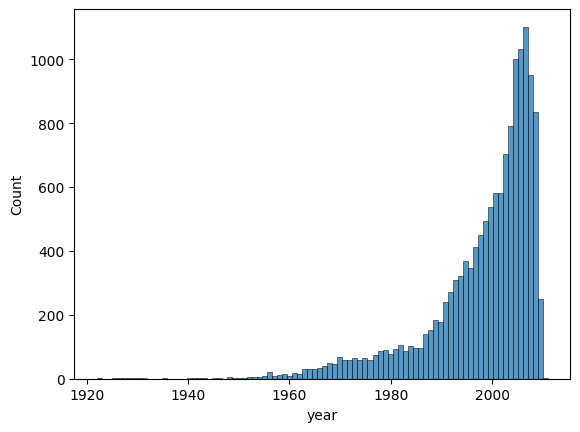

In [143]:
sns.histplot(y_train, x='year')

<Axes: >

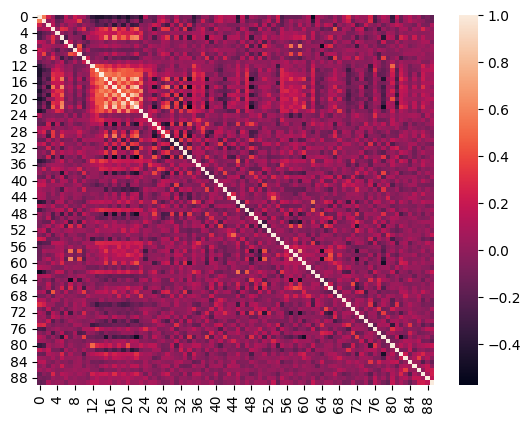

In [144]:
sns.heatmap(X_train.corr())

# Training

In [145]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [147]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(90, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, X):
        return self.fc(X)

In [148]:
EPOCHS = 100
LEARNING_RATE = 0.1

In [149]:
model = MyModel()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

loss_history: list[float] = []
for _ in (pbar := tqdm(range(EPOCHS), file=sys.stdout)):
    model.train()
    optimizer.zero_grad()

    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        loss_val: float = loss_fn(y_pred, y_test).item()
        loss_history.append(loss_val)
        tqdm.set_description(pbar, f"Loss: {loss_val:.4f}")


Loss: 0.7127: 100%|██████████| 100/100 [00:06<00:00, 14.84it/s]


(1.0, 100.0)

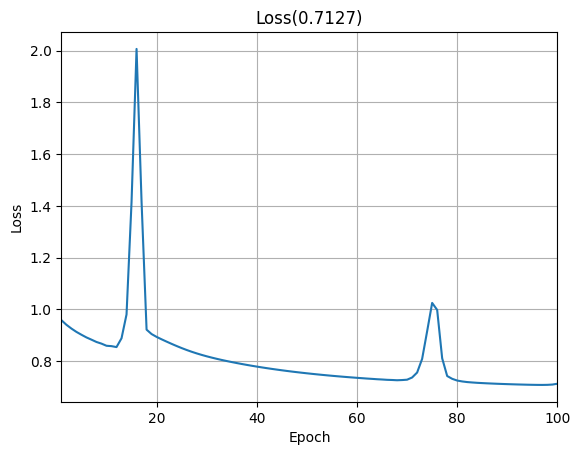

In [150]:
plt.plot(range(1, EPOCHS + 1), loss_history)
plt.title(f"Loss({loss_history[-1]:.4f})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.xlim(1, EPOCHS)

# Evaluation

In [151]:
X_train = pd.read_csv("../datasets/songs-prediction-2025/train_x.csv", index_col=0)
y_train = pd.read_csv("../datasets/songs-prediction-2025/train_y.csv", index_col=0)
X_test = pd.read_csv("../datasets/songs-prediction-2025/test_x.csv", index_col='id')
X_test_index = X_test.index

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)

X_test = X_scaler.transform(X_test)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)

In [152]:
model = MyModel()
for _ in tqdm(range(EPOCHS), file=sys.stdout):
    model.train()
    optimizer.zero_grad()

    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


In [153]:
model.eval()
with torch.no_grad():
    y_pred = y_scaler.inverse_transform(model(X_test)).astype(int)

In [154]:
pd.DataFrame({ "id": X_test_index, "year": y_pred.flatten() }).to_csv("../datasets/songs-prediction-2025/test_y.csv", index=False)